# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Importing needed packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import seaborn as sb
import datetime
%matplotlib inline

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree

# Portfolio Dataset

### Reading the data in 

In [2]:
# read in the json file
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

# taking a look at the dataset
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


## Data exploration

Lets do some descriptive exploration on the data

In [3]:
# concise summary of the dataframe
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
# summary statistics  
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [5]:
# detecting any missing values 
print('Missing values: {}\n'.format(portfolio.isna().any().any()))

Missing values: False



### Unique values in the dataset

In [6]:
# channels used to deliver the offers
portfolio['channels'].unique

<bound method Series.unique of 0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object>

In [7]:
# types of offers
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

#### After doing some exploration on the dataset can conclude the following:
  * There are no missing values in the dataset.
  * There are 4 channels through which to deliver the offers: web, email, mobile and social.
  * There are 3 different type offers: dicount, bogo, informational. 

In [8]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


## Data cleaning

In [9]:
# rename id column to offer_id
portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [10]:
# for a better representation, encode the channels column
portfolio['web']=portfolio['channels'].apply(lambda x:1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x:1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x:1 if 'mobile' in x else 0)
portfolio['social'] = portfolio ['channels'].apply(lambda x:1 if 'social' in x else 0)
# drop the channels column
portfolio.drop('channels', axis=1,inplace=True)
# reindex the portfolio dataset
portfolio.reindex(['offer_id','offer_type','duration','difficulty','reward','web','email','mobile','social'],axis=1)

,offer_id,offer_type,duration,difficulty,reward,web,email,mobile,social
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7,10,10,0,1,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,5,10,10,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,1,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,1,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,20,5,1,1,0,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,7,3,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,2,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,informational,3,0,0,0,1,1,1
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,discount,7,10,2,1,1,1,0


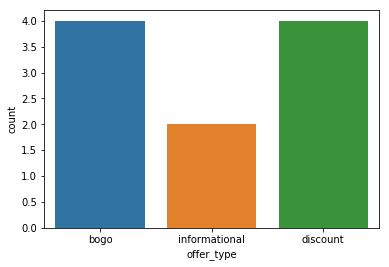

In [11]:
sns.countplot(portfolio['offer_type'])

# Profile Dataset

### Reading the data in 

In [12]:
# read in the json file
profile = pd.read_json('data/profile.json', orient='records', lines=True)

# taking a look at the dataset
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


## Data exploration

Lets do some descriptive exploration on the data

In [13]:
# concise summary of the dataframe
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [14]:
# confirm there are missing values 
print('Missing values: {}\n'.format(profile.isna().any().any()))

Missing values: True



Now that we know there are null values, in the data cleaning section will identify where these values occur and how to resolve them. 

In [15]:
# summary statistics  
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [16]:
# printing the sum of missing values
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [17]:
# shape of the dataframe
profile.shape

(17000, 5)

### Unique values in the dataset

In [18]:
# types of gender that use Starbucks
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

#### After doing some exploration on the dataset can conclude the following:
  * The number of missing values in our dataset add up to 2175. These missing values occur in 'gender' and 'income' columns. 
  * There are 3 gender groups: Male, Female and Other. 'Other' group contribute to a small portion of the dataset. During data cleaning and analysis will see whether or not that group is crucial for our modelling and predictions.  

## Data cleaning

We know from before that the null values occur in gender and income columns. Therefore its time now to start analyzing where these null values occur. In our dataset, we have three main columns where we can generate results from, these are: gender, income and age. Let's start viewing the age column with the gender and income columns. 

In [19]:
profile[['age','gender', 'income']].head()

,age,gender,income
0,118,None,NaN
1,55,F,112000.0
2,118,None,NaN
3,75,F,100000.0
4,118,None,NaN


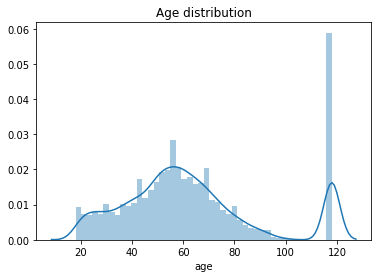

In [20]:
plt.title("Age distribution")
sns.distplot(profile['age'], kde=True)
plt.show()

From the above graph we can see the unusual and odd representation comes where age is 118. Let's print the entries with age equal to 118. 

In [21]:
# dataframe for gender and income when age equal 118. 
profile[['age','gender', 'income']][profile['age']==118].head(10)

,age,gender,income
0,118,None,NaN
2,118,None,NaN
4,118,None,NaN
6,118,None,NaN
7,118,None,NaN
9,118,None,NaN
10,118,None,NaN
11,118,None,NaN
17,118,None,NaN
23,118,None,NaN


Looks like entries for age equal to 118 have null values. Lets check the number of null values where age is 118. 

In [22]:
len(profile[profile['age'] == 118])

2175

This is the same number of null values in the gender and income columns. Thus we can confirm that those values correspond to customers at age 118. Since, there are no infromation about those customers we will go ahead and drop them.

In [23]:
# drop the rows that contain null values
profile.dropna(inplace=True)

In [24]:
# shape of the dataframe after dropping null values
profile.shape

(14825, 5)

In [25]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [26]:
# confirm there are no missing values
print('Missing values: {}\n'.format(profile.isna().any().any()))

Missing values: False



In [27]:
# summary statistics after dropping age =118
profile.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [28]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [29]:
# adjust the 'became_member_on' column to datetime
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")
#add new columns for month & year
profile['month_member'] = profile['became_member_on'].apply(lambda x: x.month)
profile['year_member'] = profile['became_member_on'].apply(lambda x: x.year)
#drop became_member_on column
profile.drop('became_member_on',axis=1, inplace=True)

In [30]:
# segmenting age for better data visualization later 
profile.loc[(profile.age == 18) & (profile.age <= 40) , 'AgeGroup'] = '18-40'
profile.loc[(profile.age >= 41) & (profile.age <= 60) , 'AgeGroup'] = '41-60'
profile.loc[(profile.age >= 61) & (profile.age <= 80) , 'AgeGroup'] = '61-80'
profile.loc[(profile.age >=81) & (profile.age <= 101) , 'AgeGroup'] = '81-101'
profile.drop('age',axis=1,inplace=True)

In [31]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
gender          14825 non-null object
id              14825 non-null object
income          14825 non-null float64
month_member    14825 non-null int64
year_member     14825 non-null int64
AgeGroup        11593 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 810.7+ KB


In [32]:
profile['AgeGroup'] = profile['AgeGroup'].fillna(profile['AgeGroup'].mode()[0])

In [33]:
profile.AgeGroup.value_counts()

41-60     9213
61-80     4556
81-101     986
18-40       70
Name: AgeGroup, dtype: int64

In [34]:
g_variables = profile[profile['gender']!= 'O']

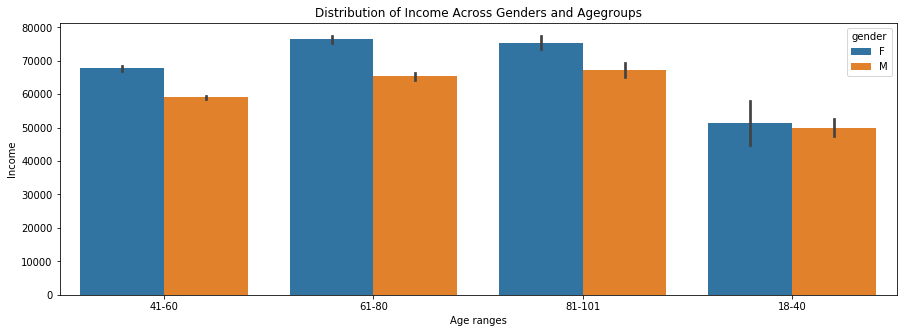

In [35]:
plt.figure(figsize=(15, 5))
sb.barplot(x = 'AgeGroup', y = 'income', hue='gender', data = g_variables);
plt.title('Distribution of Income Across Genders and Agegroups');
plt.xlabel('Age ranges');
plt.ylabel('Income');

In [36]:
g_variables.groupby('AgeGroup').income.mean()

AgeGroup
18-40     50228.571429
41-60     62370.011025
61-80     70466.325850
81-101    71839.835729
Name: income, dtype: float64

In [37]:
g_variables['AgeGroup'].value_counts()

41-60     9070
61-80     4499
81-101     974
18-40       70
Name: AgeGroup, dtype: int64

## Analyzing male customers 

In [38]:
gender_variables = profile[profile['gender']=='M']

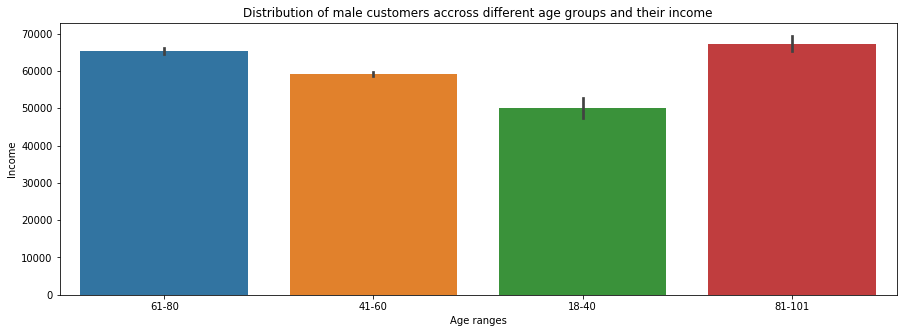

In [39]:
plt.figure(figsize=(15, 5))
sb.barplot(x = 'AgeGroup', y = 'income', data = gender_variables);
plt.title('Distribution of male customers accross different age groups and their income');
plt.xlabel('Age ranges');
plt.ylabel('Income');

In [40]:
gender_variables.groupby('AgeGroup').income.mean()

AgeGroup
18-40     49964.285714
41-60     59096.756949
61-80     65301.541025
81-101    67318.072289
Name: income, dtype: float64

In [41]:
gender_variables['AgeGroup'].value_counts()

41-60     5612
61-80     2401
81-101     415
18-40       56
Name: AgeGroup, dtype: int64

## Analyzing female customers 

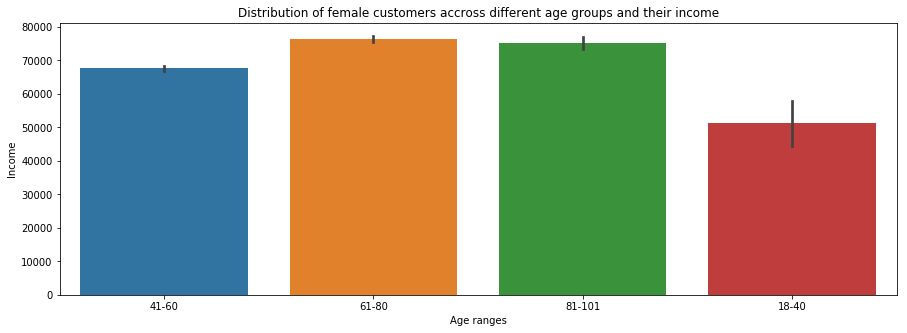

In [42]:
gender_variables1 = profile[profile['gender']=='F']
plt.figure(figsize=(15, 5))
sb.barplot(x = 'AgeGroup', y = 'income', data = gender_variables1);
plt.title('Distribution of female customers accross different age groups and their income');
plt.xlabel('Age ranges');
plt.ylabel('Income');

In [43]:
gender_variables1.groupby('AgeGroup').income.mean()

AgeGroup
18-40     51285.714286
41-60     67682.186235
61-80     76377.025739
81-101    75196.779964
Name: income, dtype: float64

In [44]:
gender_variables1['AgeGroup'].value_counts()

41-60     3458
61-80     2098
81-101     559
18-40       14
Name: AgeGroup, dtype: int64

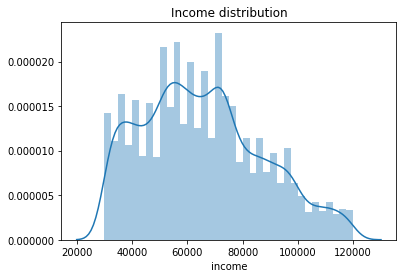

In [48]:
plt.title("Income distribution")
sns.distplot(profile['income'])

In [49]:
# split income into groups
profile.loc[(profile.income == 30000) & (profile.income <= 59999) , 'IncomeGroup'] = 'low'
profile.loc[(profile.income >= 60000) & (profile.income <= 89999) , 'IncomeGroup'] = 'medium'
profile.loc[(profile.income >= 90000) & (profile.income <= 120000) ,'IncomeGroup'] = 'high'
profile.drop('income',axis=1,inplace=True)

In [50]:
# rename id column to customer_id
profile.rename(columns={'id':'customer_id'},inplace=True)

In [51]:
# replacing null values in IncomeGroup column with mode
profile['IncomeGroup']=profile['IncomeGroup'].fillna(profile['IncomeGroup'].mode()[0])

In [52]:
# reindex the profile dataset
profile.reindex(['customer_id','gender','AgeGroup','IncomeGroup','month_member','year_member'],axis=1).head(5)

,customer_id,gender,AgeGroup,IncomeGroup,month_member,year_member
1,0610b486422d4921ae7d2bf64640c50b,F,41-60,high,7,2017
3,78afa995795e4d85b5d9ceeca43f5fef,F,61-80,high,5,2017
5,e2127556f4f64592b11af22de27a7932,M,61-80,medium,4,2018
8,389bc3fa690240e798340f5a15918d5c,M,61-80,medium,2,2018
12,2eeac8d8feae4a8cad5a6af0499a211d,M,41-60,medium,11,2017


In [53]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
gender          14825 non-null object
customer_id     14825 non-null object
month_member    14825 non-null int64
year_member     14825 non-null int64
AgeGroup        14825 non-null object
IncomeGroup     14825 non-null object
dtypes: int64(2), object(4)
memory usage: 810.7+ KB


In [54]:
profile.AgeGroup.value_counts()

41-60     9213
61-80     4556
81-101     986
18-40       70
Name: AgeGroup, dtype: int64

In [55]:
profile.IncomeGroup.value_counts()

medium    12429
high       2308
low          88
Name: IncomeGroup, dtype: int64

In [56]:
profile.year_member.value_counts()

2017    5599
2018    3669
2016    3024
2015    1597
2014     662
2013     274
Name: year_member, dtype: int64

In [57]:
profile.month_member.value_counts()

8     1395
10    1386
12    1372
1     1327
9     1299
11    1268
7     1189
5     1152
4     1145
3     1145
6     1105
2     1042
Name: month_member, dtype: int64

In [58]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

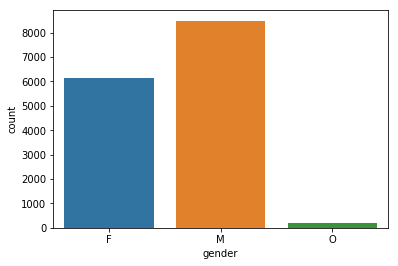

In [59]:
sns.countplot(profile['gender'])

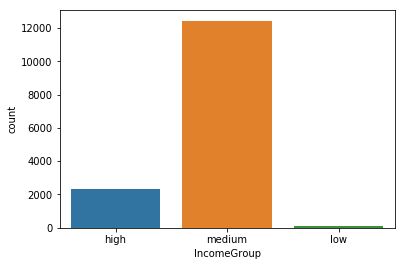

In [60]:
sns.countplot(profile['IncomeGroup'])

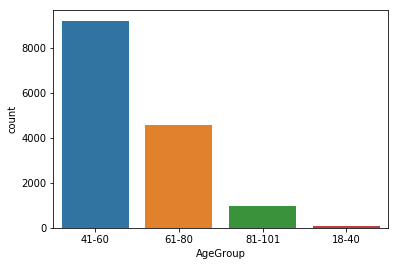

In [61]:
sns.countplot(profile['AgeGroup'])

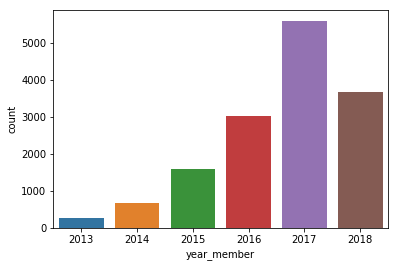

In [62]:
sns.countplot(profile['year_member'])

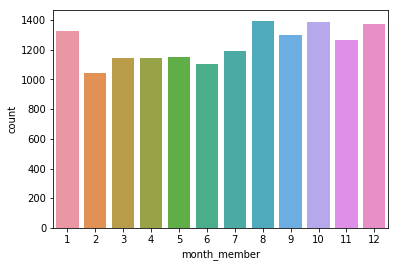

In [63]:
sns.countplot(profile['month_member'])

# Transcript Dataset

### Reading the data in 

In [64]:
# read in the json file
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# taking a look at the dataset 
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Data exploration

Lets do some descriptive exploration on the data

In [65]:
# concise summary of the dataframe
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [66]:
# confirm any missing values 
print('Missing values: {}\n'.format(transcript.isna().any().any()))

Missing values: False



In [67]:
# summary statistics  
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [68]:
# shape of the dataframe
transcript.shape

(306534, 4)

### Unique values in the dataset

In [69]:
# types of event
print(transcript['event'].unique())
print(transcript['event'].value_counts())

['offer received' 'offer viewed' 'transaction' 'offer completed']
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64


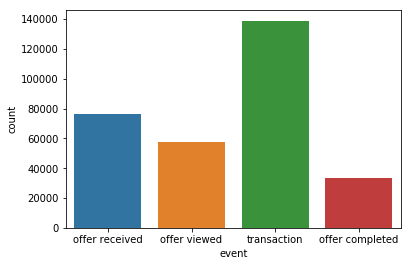

In [70]:
sns.countplot(transcript['event'])

In [71]:
# the keys in value column 
keys = []
for x, y in transcript.iterrows():
    for i in y['value']:
        if i in keys:
            continue
        else:
            keys.append(i)
keys

['offer id', 'amount', 'offer_id', 'reward']

### After doing some exploration on the dataset can conclude the following:
  * There are no null values. 
  * There are 4 different events: offer recieved, offer viewed, transaction and offer completed.
  * There are 4 different keys in the value column: amount, offer_id, offer id and reward.

## Data cleaning

In [72]:
# expanding the keys in the value column to 4 seperate columns
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id'))
transcript['offer id'] = transcript['value'].apply(lambda x: x.get('offer id'))
transcript['reward'] = transcript['value'].apply(lambda x: x.get('reward'))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount'))

In [73]:
# concatenate offer_id and offer id into one column
transcript['concat'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), \
                                  transcript['offer_id'],transcript['offer id'])

In [74]:
# dropping value, offer_id and offer id columns
transcript.drop(['value', 'offer id','offer_id'], axis=1,inplace=True)

In [75]:
# for preprocessing and readability, rename concat column to offer_id
transcript.rename(columns={'concat':'offer_id'}, inplace = True)
# rename person to customer_id
transcript.rename(columns={'person':'customer_id'}, inplace = True)

In [76]:
transcript.head()

,event,customer_id,time,reward,amount,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [77]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
event          306534 non-null object
customer_id    306534 non-null object
time           306534 non-null int64
reward         33579 non-null float64
amount         138953 non-null float64
offer_id       167581 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


In [78]:
# replacing null values in 'reward', 'amount' with mean
transcript['reward'] = transcript['reward'].fillna(transcript['reward'].mean())
transcript['amount'] = transcript['amount'].fillna(transcript['amount'].mean())

In [79]:
# replacing null values in offer_id with the last observation forward
transcript['offer_id'] = transcript['offer_id'].fillna(transcript['offer_id'].ffill())

In [80]:
# confirm there are no missing values 
print('Missing values: {}\n'.format(transcript.isna().any().any()))

Missing values: False



In [81]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
event          306534 non-null object
customer_id    306534 non-null object
time           306534 non-null int64
reward         306534 non-null float64
amount         306534 non-null float64
offer_id       306534 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


In [82]:
transcript.tail()

,event,customer_id,time,reward,amount,offer_id
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,4.904137,1.59,fafdcd668e3743c1bb461111dcafc2a4
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,4.904137,9.53,fafdcd668e3743c1bb461111dcafc2a4
306531,transaction,a00058cf10334a308c68e7631c529907,714,4.904137,3.61,fafdcd668e3743c1bb461111dcafc2a4
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,4.904137,3.53,fafdcd668e3743c1bb461111dcafc2a4
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,4.904137,4.05,fafdcd668e3743c1bb461111dcafc2a4


In [83]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [84]:
# Merge datasets
def merge_datasets (portfolio,profile,transcript):
    """
    Merge three datasets for analysis and modelling.
    
    Input
    ------
    portfolio: containing offer ids and meta data about each offer
    profile: demographic data for each customer
    transcript: records for transaction, offers received, offers viewed and offers completed. 
    
    Output
    ------
    
    merged datasets
    
    """
    
    merge = pd.merge(portfolio,transcript, on= 'offer_id')
    merged_datasets = pd.merge(merge,profile, on= 'customer_id')
    
    return merged_datasets

In [121]:
merged_datasets = merge_datasets(portfolio, profile, transcript)
merged_datasets.head()

,difficulty,duration,offer_id,offer_type,reward_x,web,email,mobile,social,event,customer_id,time,reward_y,amount,gender,month_member,year_member,AgeGroup,IncomeGroup
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,4.904137,12.777356,M,9,2017,61-80,high
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,4.904137,12.777356,M,9,2017,61-80,high
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,4.904137,12.777356,M,9,2017,61-80,high
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,4.904137,12.777356,M,9,2017,61-80,high
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,transaction,4b0da7e80e5945209a1fdddfe813dbe0,510,4.904137,31.050000,M,9,2017,61-80,high


In [122]:
merged_datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 19 columns):
difficulty      272762 non-null int64
duration        272762 non-null int64
offer_id        272762 non-null object
offer_type      272762 non-null object
reward_x        272762 non-null int64
web             272762 non-null int64
email           272762 non-null int64
mobile          272762 non-null int64
social          272762 non-null int64
event           272762 non-null object
customer_id     272762 non-null object
time            272762 non-null int64
reward_y        272762 non-null float64
amount          272762 non-null float64
gender          272762 non-null object
month_member    272762 non-null int64
year_member     272762 non-null int64
AgeGroup        272762 non-null object
IncomeGroup     272762 non-null object
dtypes: float64(2), int64(10), object(7)
memory usage: 41.6+ MB


# Data visualization

### Gender Distribution

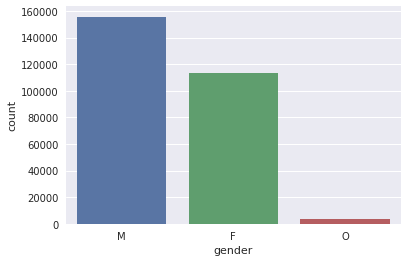

In [123]:
sns.countplot(merged_datasets['gender'])

In [124]:
merged_datasets.gender.value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

### AgeGroup distribution

In [125]:
agegroup_dist =   merged_datasets.AgeGroup.value_counts().index

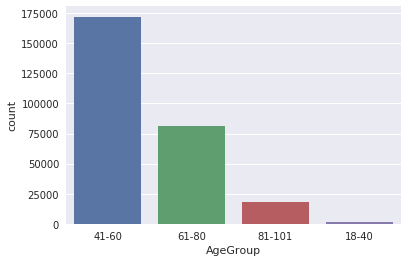

In [126]:
sns.countplot(x='AgeGroup' , data = merged_datasets, order = agegroup_dist);

In [127]:
merged_datasets.AgeGroup.value_counts()

41-60     172064
61-80      81524
81-101     17807
18-40       1367
Name: AgeGroup, dtype: int64

### Income distrubution

In [128]:
income_dist = merged_datasets.IncomeGroup.value_counts().index

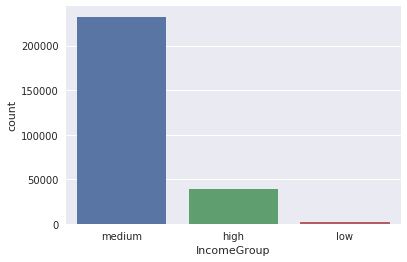

In [129]:
sns.countplot(x='IncomeGroup' , data = merged_datasets, order = income_dist);

### Offer_type distribution 

In [130]:
offertype_dist = merged_datasets.offer_type.value_counts().index

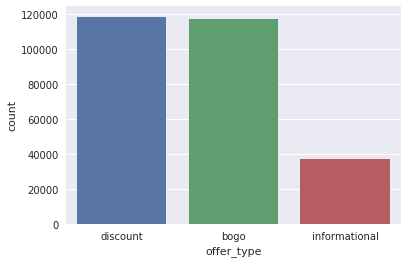

In [131]:
sns.countplot(x= 'offer_type', data = merged_datasets, order = offertype_dist);

In [132]:
merged_datasets.offer_type.value_counts()

discount         118385
bogo             117080
informational     37297
Name: offer_type, dtype: int64

### Event disribution

In [133]:
event_dist = merged_datasets.event.value_counts().index

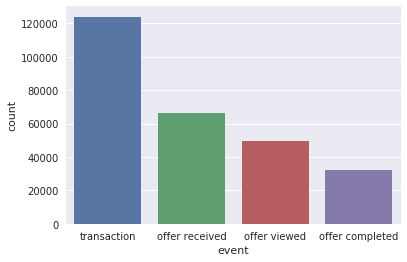

In [134]:
sns.countplot(x= 'event', data = merged_datasets, order = event_dist);

In [135]:
merged_datasets.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

### Distribution of Gender in each AgeGroup

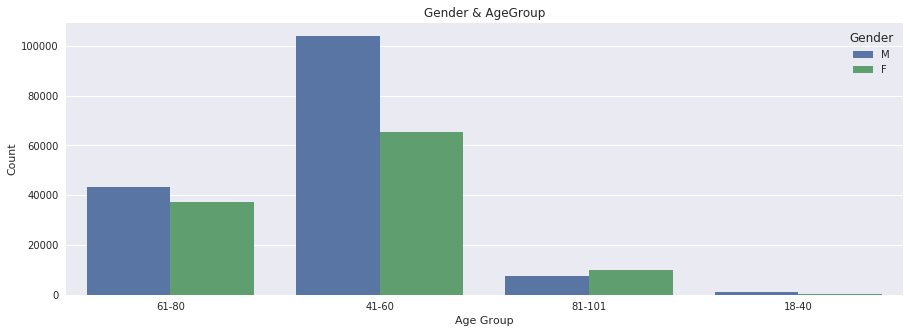

In [136]:
gender_variables = merged_datasets[merged_datasets['gender'] != 'O']
plt.figure(figsize=(15, 5))
sns.countplot(x= "AgeGroup", hue= "gender", data=gender_variables)
sns.set(style="darkgrid")
plt.title('Gender & AgeGroup')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

### Distribution of Gender in each IncomeGroup

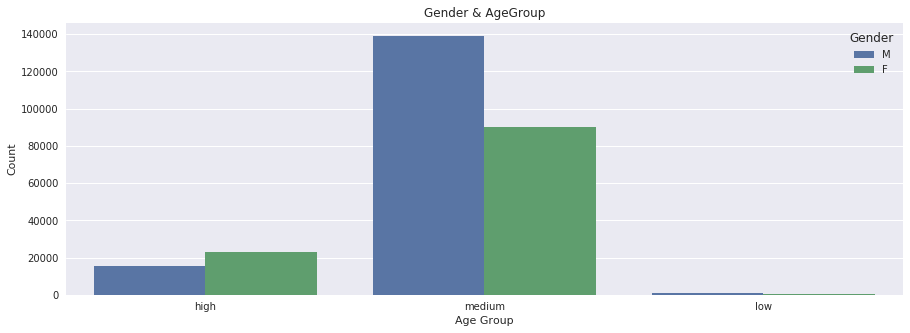

In [137]:
gender_variables = merged_datasets[merged_datasets['gender'] != 'O']
plt.figure(figsize=(15, 5))
sns.countplot(x= "IncomeGroup", hue= "gender", data=gender_variables)
sns.set(style="darkgrid")
plt.title('Gender & AgeGroup')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

### Distribution of Gender in each Offer Type

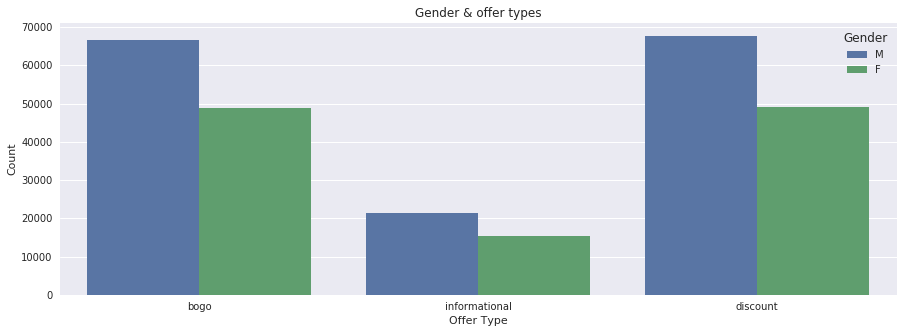

In [138]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=gender_variables)
sns.set(style="darkgrid")
plt.title('Gender & offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

### Distribution of Gender in each Event

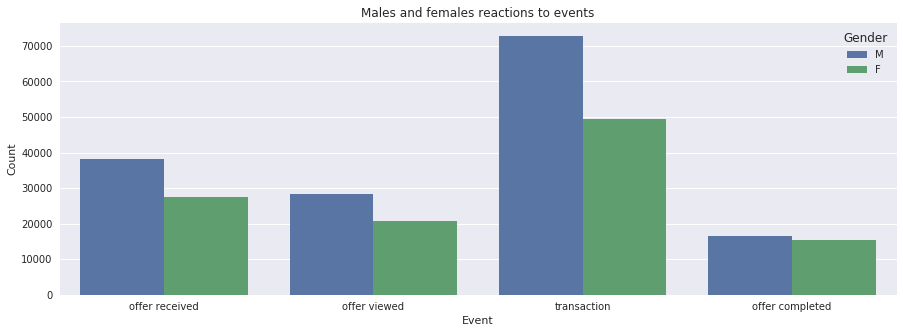

In [139]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "gender", data=gender_variables)
sns.set(style="darkgrid")
plt.title('Males and females reactions to events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender')

### Distribution of Offer types in each Event

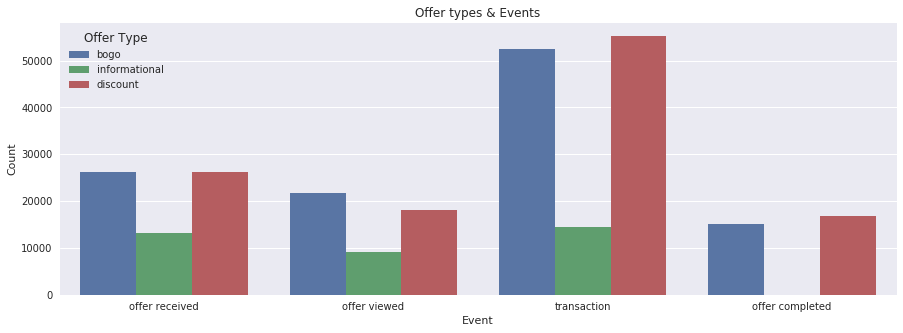

In [140]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=gender_variables)
sns.set(style="darkgrid")
plt.title('Offer types & Events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

### Distribution of Gender in each Event

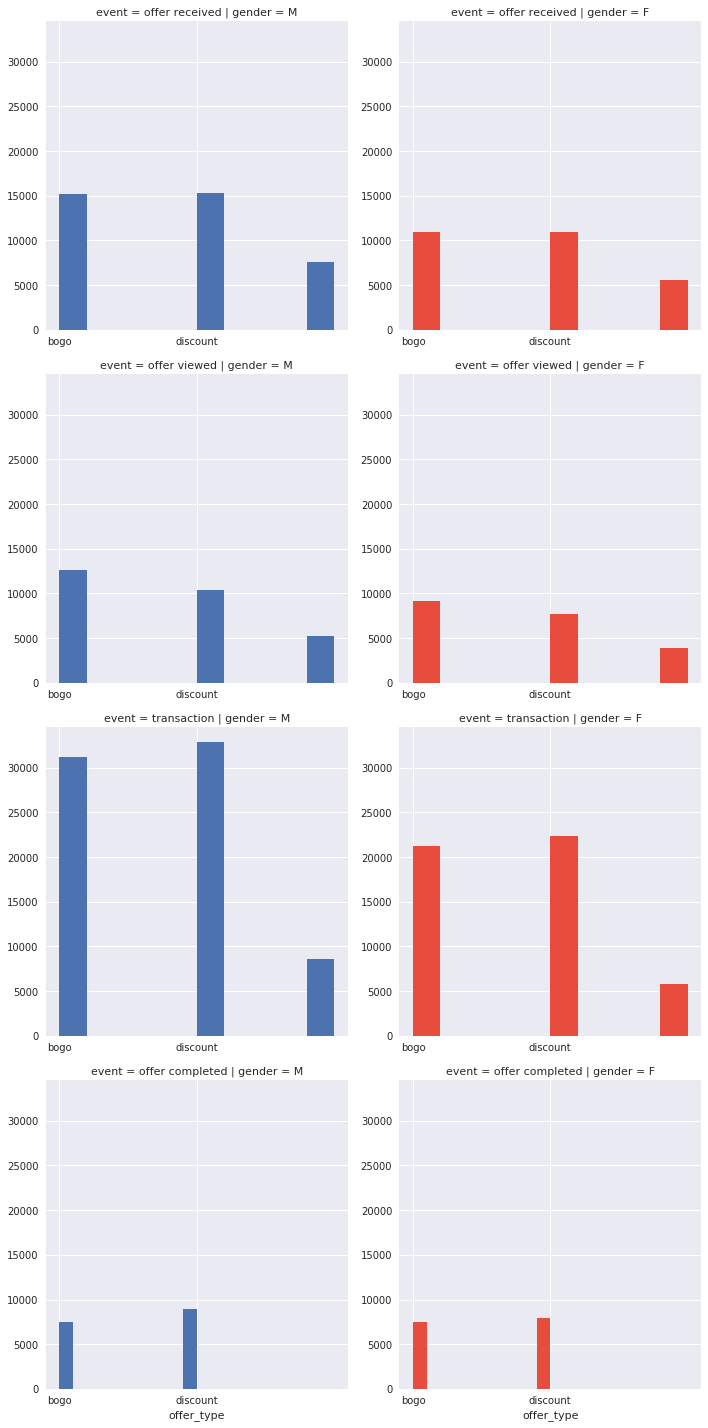

In [141]:
d = {'color': ['C0', "#e74c3c"]}
g = sns.FacetGrid(gender_variables, row='event', col='gender', hue_kws=d, hue='gender', size=5)
g.map(plt.hist, 'offer_type')

# Distribution of income in offer types

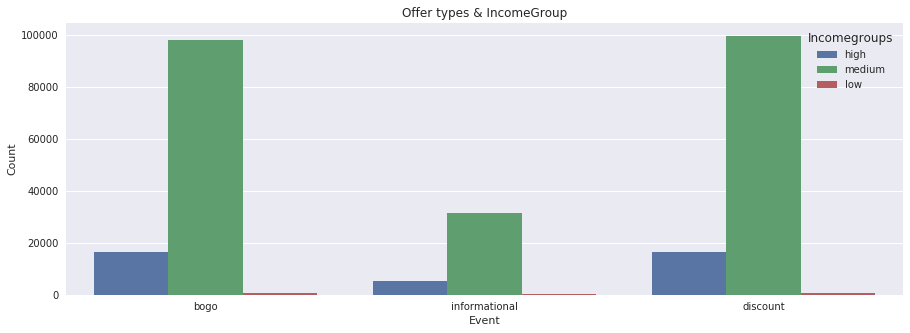

In [142]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "IncomeGroup", data=gender_variables)
sns.set(style="darkgrid")
plt.title('Offer types & IncomeGroup')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Incomegroups')

# Data preprocessing 

In [143]:
merged_datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 19 columns):
difficulty      272762 non-null int64
duration        272762 non-null int64
offer_id        272762 non-null object
offer_type      272762 non-null object
reward_x        272762 non-null int64
web             272762 non-null int64
email           272762 non-null int64
mobile          272762 non-null int64
social          272762 non-null int64
event           272762 non-null object
customer_id     272762 non-null object
time            272762 non-null int64
reward_y        272762 non-null float64
amount          272762 non-null float64
gender          272762 non-null object
month_member    272762 non-null int64
year_member     272762 non-null int64
AgeGroup        272762 non-null object
IncomeGroup     272762 non-null object
dtypes: float64(2), int64(10), object(7)
memory usage: 51.6+ MB


In [144]:
merged_datasets.head()

,difficulty,duration,offer_id,offer_type,reward_x,web,email,mobile,social,event,customer_id,time,reward_y,amount,gender,month_member,year_member,AgeGroup,IncomeGroup
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,4.904137,12.777356,M,9,2017,61-80,high
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,4.904137,12.777356,M,9,2017,61-80,high
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,4.904137,12.777356,M,9,2017,61-80,high
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,4.904137,12.777356,M,9,2017,61-80,high
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,transaction,4b0da7e80e5945209a1fdddfe813dbe0,510,4.904137,31.050000,M,9,2017,61-80,high


In [145]:
# transforming and scalling features
scaler = MinMaxScaler() 
numerical = ['difficulty','duration','time','reward_x','reward_y','amount']
# fitting and transforming the features
merged_datasets[numerical] = scaler.fit_transform(merged_datasets[numerical])
# converting categorical columns into indicator variables
categorical = ['gender','AgeGroup','offer_type', 'IncomeGroup','event']
merged_datasets= pd.get_dummies(merged_datasets, columns = categorical)   

In [146]:
merged_datasets.head()

,difficulty,duration,offer_id,reward_x,web,email,mobile,social,customer_id,time,...,offer_type_bogo,offer_type_discount,offer_type_informational,IncomeGroup_high,IncomeGroup_low,IncomeGroup_medium,event_offer completed,event_offer received,event_offer viewed,event_transaction
0,0.5,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,1.0,0,1,1,1,4b0da7e80e5945209a1fdddfe813dbe0,0.000000,...,1,0,0,1,0,0,0,1,0,0
1,0.5,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,1.0,0,1,1,1,4b0da7e80e5945209a1fdddfe813dbe0,0.142857,...,1,0,0,1,0,0,0,0,1,0
2,0.5,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,1.0,0,1,1,1,4b0da7e80e5945209a1fdddfe813dbe0,0.705882,...,1,0,0,1,0,0,0,1,0,0
3,0.5,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,1.0,0,1,1,1,4b0da7e80e5945209a1fdddfe813dbe0,0.714286,...,1,0,0,1,0,0,0,0,1,0
4,0.5,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,1.0,0,1,1,1,4b0da7e80e5945209a1fdddfe813dbe0,0.714286,...,1,0,0,1,0,0,0,0,0,1


# Model evaluation

In [147]:
merged_datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 31 columns):
difficulty                  272762 non-null float64
duration                    272762 non-null float64
offer_id                    272762 non-null object
reward_x                    272762 non-null float64
web                         272762 non-null int64
email                       272762 non-null int64
mobile                      272762 non-null int64
social                      272762 non-null int64
customer_id                 272762 non-null object
time                        272762 non-null float64
reward_y                    272762 non-null float64
amount                      272762 non-null float64
month_member                272762 non-null int64
year_member                 272762 non-null int64
gender_F                    272762 non-null uint8
gender_M                    272762 non-null uint8
gender_O                    272762 non-null uint8
AgeGroup_18-40           

### Creating train and test datasets

In [148]:
X = merged_datasets.drop(columns=['event_offer completed','offer_id','customer_id'])
Y = merged_datasets['event_offer completed']

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)
print("Training set: {} ".format(X_train.shape))
print("Testing set: {} ".format(X_test.shape))

Training set: (190933, 28) 
Testing set: (81829, 28) 


## Machine Learning Algorithms

### 1. Random forest classifier 

In [150]:
# perform random classifier model
rforest = RandomForestClassifier()
# train the model
rforest.fit(X_train,y_train)
# predictions on model
y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)
# Training set performance
rforest_train_accuracy = accuracy_score(y_train,y_train_pred)
rforest_train_f1 = f1_score(y_train,y_train_pred,average='weighted')
rforest_train_cm = confusion_matrix(y_train,y_train_pred)
rforest_train_cr = classification_report(y_train,y_train_pred)
# Testing set performance
rforest_test_accuracy = accuracy_score(y_test,y_test_pred)
rforest_test_f1 = f1_score(y_test,y_test_pred,average='weighted')
rforest_test_cm = confusion_matrix(y_test,y_test_pred)
rforest_test_cr = classification_report(y_test,y_test_pred)
print('Model performance for Training set')
print('Accuracy: %s' % rforest_train_accuracy)
print('F1 score: %s' % rforest_train_f1)
print('Classification report:\n' ,rforest_train_cm)
print('Confusion matrix:\n' ,rforest_train_cm)
print('-----------')
print('Model performance for Testing set')
print('Accuracy: %s' % rforest_test_accuracy)
print('F1 score: %s' % rforest_test_f1)
print('Classification report:\n', rforest_test_cr)
print('Confusion matrix: \n', rforest_test_cm)

Model performance for Training set
Accuracy: 1.0
F1 score: 1.0
Classification report:
 [[168314      0]
 [     0  22619]]
Confusion matrix:
 [[168314      0]
 [     0  22619]]
-----------
Model performance for Testing set
Accuracy: 1.0
F1 score: 1.0
Classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     72004
          1       1.00      1.00      1.00      9825

avg / total       1.00      1.00      1.00     81829

Confusion matrix: 
 [[72004     0]
 [    0  9825]]


### 2. KNeighbors classifier 

In [151]:
# define the kneighbour classifier
knn = KNeighborsClassifier()
# train the model
knn.fit(X_train,y_train)
# predictions on model
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
# Training set performance
knn_train_accuracy = accuracy_score(y_train,y_train_pred)
knn_train_f1 = f1_score(y_train,y_train_pred,average='weighted')
knn_train_cm = confusion_matrix(y_train,y_train_pred)
knn_train_cr = classification_report(y_train,y_train_pred)
# Testing set performance
knn_test_accuracy = accuracy_score(y_test,y_test_pred)
knn_test_f1 = f1_score(y_test,y_test_pred,average='weighted')
knn_test_cm = confusion_matrix(y_test,y_test_pred)
knn_test_cr = classification_report(y_test,y_test_pred)
print('Model performance for Training set')
print('Accuracy: %s' % knn_train_accuracy)
print('F1 score: %s' % knn_train_f1)
print('Classification report:\n' , knn_train_cr)
print('Confusion matrix:\n' ,knn_train_cm)
print('-----------')
print('Model performance for Testing set')
print('-Accuracy: %s' % knn_test_accuracy)
print('-F1 score: %s' % knn_test_f1)
print('Classification report:\n' , knn_test_cr)
print('Confusion matrix:\n' ,knn_test_cm)

Model performance for Training set
Accuracy: 0.996668988598
F1 score: 0.996653367901
Classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00    168314
          1       1.00      0.98      0.99     22619

avg / total       1.00      1.00      1.00    190933

Confusion matrix:
 [[168238     76]
 [   560  22059]]
-----------
Model performance for Testing set
-Accuracy: 0.993571961041
-F1 score: 0.993519993907
Classification report:
              precision    recall  f1-score   support

          0       0.99      1.00      1.00     72004
          1       0.99      0.95      0.97      9825

avg / total       0.99      0.99      0.99     81829

Confusion matrix:
 [[71921    83]
 [  443  9382]]


### 3. Naive Bayes

In [152]:
# creating a model
nbayes = GaussianNB()
# train the model
nbayes.fit(X_train,y_train)
# predictions on model
y_train_pred = nbayes.predict(X_train)
y_test_pred = nbayes.predict(X_test)
# Training set performance
nbayes_train_accuracy = accuracy_score(y_train,y_train_pred)
nbayes_train_f1 = f1_score(y_train,y_train_pred,average='weighted')
nbayes_train_cm = confusion_matrix(y_train,y_train_pred)
nbayes_train_cr = classification_report(y_train,y_train_pred)
# Testing set performance
nbayes_test_accuracy = accuracy_score(y_test,y_test_pred)
nbayes_test_f1 = f1_score(y_test,y_test_pred,average='weighted')
nbayes_test_cm = confusion_matrix(y_test,y_test_pred)
nbayes_test_cr = classification_report(y_test,y_test_pred)
print('Model performance for Training set')
print('Accuracy: %s' % nbayes_train_accuracy)
print('F1 score: %s' % nbayes_train_f1)
print('Classification report:\n' , nbayes_train_cr)
print('Confusion matrix:\n' , nbayes_train_cm)
print('-----------')
print('Model performance for Testing set')
print('Accuracy: %s' % nbayes_test_accuracy)
print('F1 score: %s' % nbayes_test_f1)
print('Classification report:\n' , nbayes_test_cr)
print('Confusion matrix:\n' , nbayes_test_cm)

Model performance for Training set
Accuracy: 1.0
F1 score: 1.0
Classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00    168314
          1       1.00      1.00      1.00     22619

avg / total       1.00      1.00      1.00    190933

Confusion matrix:
 [[168314      0]
 [     0  22619]]
-----------
Model performance for Testing set
Accuracy: 1.0
F1 score: 1.0
Classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     72004
          1       1.00      1.00      1.00      9825

avg / total       1.00      1.00      1.00     81829

Confusion matrix:
 [[72004     0]
 [    0  9825]]


### 4. Decision Tree

In [153]:
# create the model
dtree = tree.DecisionTreeClassifier()
# train the model
dtree.fit(X_train,y_train)
# predictions on model
y_train_pred = dtree.predict(X_train)
y_test_pred = dtree.predict(X_test)
# Training set performance
dtree_train_accuracy = accuracy_score(y_train,y_train_pred)
dtree_train_f1 = f1_score(y_train,y_train_pred,average='weighted')
dtree_train_cm = confusion_matrix(y_train,y_train_pred)
dtree_train_cr = classification_report(y_train,y_train_pred)
# Testing set performance
dtree_test_accuracy = accuracy_score(y_test,y_test_pred)
dtree_test_f1 = f1_score(y_test,y_test_pred,average='weighted')
dtree_test_cm = confusion_matrix(y_test,y_test_pred)
dtree_test_cr = classification_report(y_test,y_test_pred)
print('Model performance for Training set')
print('Accuracy: %s' % dtree_train_accuracy)
print('F1 score: %s' % dtree_train_f1)
print('Classification report:\n', dtree_train_cr)
print('Confusion matrix:\n', dtree_train_cm)
print('-----------')
print('Model performance for Testing set')
print('Accuracy: %s' % dtree_test_accuracy)
print('F1 score: %s' % dtree_test_f1)
print('Classification report:\n' , dtree_test_cr)
print('Confusion matrix:\n' , dtree_test_cm)

Model performance for Training set
Accuracy: 1.0
F1 score: 1.0
Classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00    168314
          1       1.00      1.00      1.00     22619

avg / total       1.00      1.00      1.00    190933

Confusion matrix:
 [[168314      0]
 [     0  22619]]
-----------
Model performance for Testing set
Accuracy: 1.0
F1 score: 1.0
Classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     72004
          1       1.00      1.00      1.00      9825

avg / total       1.00      1.00      1.00     81829

Confusion matrix:
 [[72004     0]
 [    0  9825]]


### 5. Logistic regression

In [154]:
# perform logistic regression
logreg = LogisticRegression()
# train the model
logreg.fit(X_train,y_train)
# predictions on model
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)
# Training set performance
logreg_train_accuracy = accuracy_score(y_train,y_train_pred)
logreg_train_f1 = f1_score(y_train,y_train_pred,average='weighted')
logreg_train_cm = confusion_matrix(y_train,y_train_pred)
logreg_train_cr = classification_report(y_train,y_train_pred)
# Testing set performance
logreg_test_accuracy = accuracy_score(y_test,y_test_pred)
logreg_test_f1 = f1_score(y_test,y_test_pred,average='weighted')
logreg_test_cm = confusion_matrix(y_test,y_test_pred)
logreg_test_cr = classification_report(y_test,y_test_pred)
print('Model performance for Training set')
print('Accuracy: %s' % logreg_train_accuracy)
print('F1 score: %s' % logreg_train_f1)
print('Classification report:\n' , logreg_train_cr)
print('Confusion matrix:\n' , logreg_train_cm)
print('-----------')
print('Model performance for Testing set')
print('Accuracy: %s' % logreg_test_accuracy)
print('F1 score: %s' % logreg_test_f1)
print('Classification report:\n' , logreg_test_cr)
print('Confusion matrix:\n' , logreg_test_cm)

Model performance for Training set
Accuracy: 1.0
F1 score: 1.0
Classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00    168314
          1       1.00      1.00      1.00     22619

avg / total       1.00      1.00      1.00    190933

Confusion matrix:
 [[168314      0]
 [     0  22619]]
-----------
Model performance for Testing set
Accuracy: 1.0
F1 score: 1.0
Classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     72004
          1       1.00      1.00      1.00      9825

avg / total       1.00      1.00      1.00     81829

Confusion matrix:
 [[72004     0]
 [    0  9825]]


## Evaluation results 

In [155]:
# evaluating results on training set 
accuracy_train_list = {'rforest':rforest_train_accuracy,
                       'knn':knn_train_accuracy,
                       'nbayes':nbayes_train_accuracy,
                       'dtree':dtree_train_accuracy,
                       'logreg':logreg_train_accuracy}

f1score_train_list = {'rforest':rforest_train_f1,
                      'knn':knn_train_f1,
                      'nbayes':nbayes_train_f1,
                      'dtree':dtree_train_f1,
                      'logreg':logreg_train_f1}

In [156]:
accuracy = (pd.DataFrame.from_dict(accuracy_train_list, orient='index',columns=['Accuracy']))
f1score = (pd.DataFrame.from_dict(f1score_train_list, orient='index',columns=['F1Score']))
df = pd.concat([accuracy,f1score],axis=1, sort=True)
df.head()

,Accuracy,F1Score
dtree,1.000000,1.000000
knn,0.996669,0.996653
logreg,1.000000,1.000000
nbayes,1.000000,1.000000
rforest,1.000000,1.000000


In [157]:
x = ['dtree','knn','logreg','nbayes','rforest']

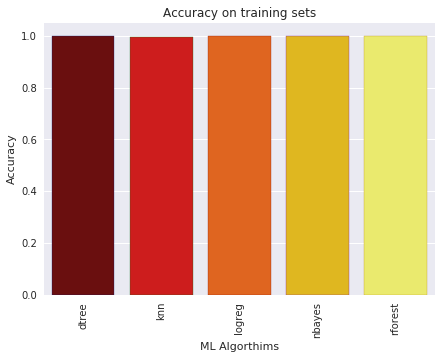

In [158]:
plt.subplots(figsize=(7,5))
sns.barplot(x, y="Accuracy",data=df,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('ML Algorthims')
plt.title('Accuracy on training sets')
plt.show()

In [159]:
# evaluating results on testing set 
accuracy_test_list = {'rforest':rforest_test_accuracy,
                       'knn':knn_test_accuracy,
                       'nbayes':nbayes_test_accuracy,
                       'dtree':dtree_test_accuracy,
                       'logreg':logreg_test_accuracy}

f1score_test_list = {'rforest':rforest_test_f1,
                      'knn':knn_test_f1,
                      'nbayes':nbayes_test_f1,
                      'dtree':dtree_test_f1,
                      'logreg':logreg_test_f1}

In [160]:
accuracy1 = (pd.DataFrame.from_dict(accuracy_test_list, orient='index',columns=['Accuracy1']))
f1score1 = (pd.DataFrame.from_dict(f1score_test_list, orient='index',columns=['F1Score1']))
df1 = pd.concat([accuracy1,f1score1],axis=1, sort=True)
df1.head()

,Accuracy1,F1Score1
dtree,1.000000,1.00000
knn,0.993572,0.99352
logreg,1.000000,1.00000
nbayes,1.000000,1.00000
rforest,1.000000,1.00000


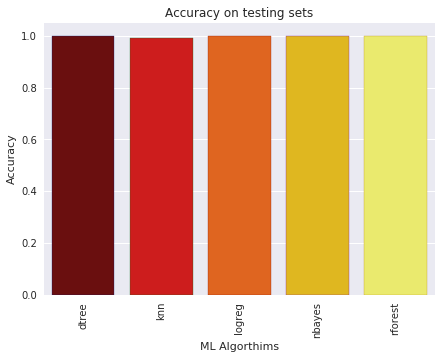

In [161]:
plt.subplots(figsize=(7,5))
sns.barplot(x, y="Accuracy1",data=df1,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('ML Algorthims')
plt.title('Accuracy on testing sets')
plt.show()